# Дообучение GPT-2 с кастомным BPE токенизатором

В этом ноутбуке мы:
1. Используем наш BPE токенизатор, обученный на русском языке
2. Заменяем им стандартный токенизатор GPT-2
3. Дообучаем GPT-2 124M на русском корпусе

In [ ]:
# Установка необходимых библиотек
# !pip install transformers datasets accelerate

In [7]:
import re
import json
import random
import math
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import regex

from transformers import GPT2LMHeadModel, GPT2Config, PreTrainedTokenizer
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset

# Устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Воспроизводимость
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Device: cuda


## 1. BPE Токенизатор

Используем оптимизированный токенизатор из предыдущего задания.

In [8]:
class BPETokenizer:    
    PRETOKENIZE_PATTERN = regex.compile(
        r"'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}|\ ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+",
        regex.UNICODE
    )
    
    def __init__(self, vocab_size: int = 10000, special_tokens: List[str] = None):
        self.vocab_size = vocab_size
        
        if special_tokens is None:
            special_tokens = ["<PAD>", "<UNK>", "<BOS>", "<EOS>", "<MASK>"]
        self.special_tokens = special_tokens
        
        self.vocab: Dict[str, int] = {}
        self.inverse_vocab: Dict[int, str] = {}
        self.merges: List[Tuple[str, str]] = []
        self.merge_ranks: Dict[Tuple[str, str], int] = {}
        self.cache: Dict[str, List[int]] = {}
        
        self._init_base_vocab()
        
    def _init_base_vocab(self):
        for i, token in enumerate(self.special_tokens):
            self.vocab[token] = i
            self.inverse_vocab[i] = token
        
        offset = len(self.special_tokens)
        for i in range(256):
            byte_token = bytes([i]).decode('latin-1')
            self.vocab[byte_token] = offset + i
            self.inverse_vocab[offset + i] = byte_token
            
    def _pretokenize(self, text: str) -> List[str]:
        tokens = self.PRETOKENIZE_PATTERN.findall(text)
        return tokens if tokens else list(text)
    
    def _text_to_bytes(self, text: str) -> Tuple[str, ...]:
        return tuple(bytes([b]).decode('latin-1') for b in text.encode('utf-8'))
    
    def _build_merge_ranks(self):
        self.merge_ranks = {merge: i for i, merge in enumerate(self.merges)}
    
    def train(self, texts: List[str], verbose: bool = True):
        if verbose:
            print("Претокенизация и подсчет частот...")
        
        word_freqs = Counter()
        for text in tqdm(texts, disable=not verbose):
            pretokens = self._pretokenize(text)
            for pretoken in pretokens:
                byte_seq = self._text_to_bytes(pretoken)
                word_freqs[byte_seq] += 1
        
        if verbose:
            print(f"Уникальных претокенов: {len(word_freqs)}")
            print("Построение индекса пар...")
        
        pair_freqs = Counter()
        pair_to_words = defaultdict(set)
        word_to_pairs = {}
        
        for word in word_freqs:
            if len(word) < 2:
                continue
            pairs_in_word = []
            for i in range(len(word) - 1):
                pair = (word[i], word[i + 1])
                pair_freqs[pair] += word_freqs[word]
                pair_to_words[pair].add(word)
                pairs_in_word.append((i, pair))
            word_to_pairs[word] = pairs_in_word
        
        num_merges = self.vocab_size - len(self.vocab)
        
        if verbose:
            print(f"Выполняем {num_merges} слияний...")
        
        pbar = tqdm(range(num_merges), disable=not verbose)
        
        for _ in pbar:
            if not pair_freqs:
                break
            
            best_pair = pair_freqs.most_common(1)[0][0]
            best_freq = pair_freqs[best_pair]
            
            if best_freq == 0:
                break
            
            new_token = best_pair[0] + best_pair[1]
            new_id = len(self.vocab)
            self.vocab[new_token] = new_id
            self.inverse_vocab[new_id] = new_token
            self.merges.append(best_pair)
            
            pbar.set_description(f"Freq={best_freq}, {best_pair[0]!r}+{best_pair[1]!r}")
            
            affected_words = list(pair_to_words[best_pair])
            del pair_to_words[best_pair]
            del pair_freqs[best_pair]
            
            for old_word in affected_words:
                if old_word not in word_freqs:
                    continue
                    
                freq = word_freqs[old_word]
                
                if old_word in word_to_pairs:
                    for pos, pair in word_to_pairs[old_word]:
                        if pair in pair_freqs:
                            pair_freqs[pair] -= freq
                            if pair_freqs[pair] <= 0:
                                del pair_freqs[pair]
                        if pair in pair_to_words:
                            pair_to_words[pair].discard(old_word)
                
                new_word = []
                i = 0
                word_list = list(old_word)
                while i < len(word_list):
                    if i < len(word_list) - 1 and word_list[i] == best_pair[0] and word_list[i + 1] == best_pair[1]:
                        new_word.append(new_token)
                        i += 2
                    else:
                        new_word.append(word_list[i])
                        i += 1
                
                new_word = tuple(new_word)
                
                del word_freqs[old_word]
                if old_word in word_to_pairs:
                    del word_to_pairs[old_word]
                
                word_freqs[new_word] += freq
                
                if len(new_word) >= 2:
                    pairs_in_word = []
                    for i in range(len(new_word) - 1):
                        pair = (new_word[i], new_word[i + 1])
                        pair_freqs[pair] += freq
                        pair_to_words[pair].add(new_word)
                        pairs_in_word.append((i, pair))
                    word_to_pairs[new_word] = pairs_in_word
        
        self._build_merge_ranks()
        self.cache.clear()
        
        if verbose:
            print(f"Финальный размер словаря: {len(self.vocab)}")
    
    def _encode_word(self, word: str) -> List[int]:
        if word in self.cache:
            return self.cache[word]
        
        tokens = list(self._text_to_bytes(word))
        
        if len(tokens) <= 1:
            result = [self.vocab.get(t, self.vocab["<UNK>"]) for t in tokens]
            self.cache[word] = result
            return result
        
        while len(tokens) > 1:
            min_rank = float('inf')
            min_idx = -1
            
            for i in range(len(tokens) - 1):
                pair = (tokens[i], tokens[i + 1])
                if pair in self.merge_ranks:
                    rank = self.merge_ranks[pair]
                    if rank < min_rank:
                        min_rank = rank
                        min_idx = i
            
            if min_idx == -1:
                break
            
            tokens = tokens[:min_idx] + [tokens[min_idx] + tokens[min_idx + 1]] + tokens[min_idx + 2:]
        
        result = [self.vocab.get(t, self.vocab["<UNK>"]) for t in tokens]
        
        if len(self.cache) < 100000:
            self.cache[word] = result
        
        return result
    
    def encode(self, text: str, add_special_tokens: bool = False) -> List[int]:
        tokens = []
        
        if add_special_tokens:
            tokens.append(self.vocab["<BOS>"])
        
        pretokens = self._pretokenize(text)
        
        for pretoken in pretokens:
            tokens.extend(self._encode_word(pretoken))
        
        if add_special_tokens:
            tokens.append(self.vocab["<EOS>"])
            
        return tokens
    
    def decode(self, token_ids: List[int]) -> str:
        byte_tokens = []
        for token_id in token_ids:
            if token_id in self.inverse_vocab:
                token = self.inverse_vocab[token_id]
                if token not in self.special_tokens:
                    byte_tokens.append(token)
        
        byte_string = ''.join(byte_tokens).encode('latin-1')
        return byte_string.decode('utf-8', errors='replace')
    
    def get_vocab_size(self) -> int:
        return len(self.vocab)
    
    @property
    def pad_token_id(self) -> int:
        return self.vocab["<PAD>"]
    
    @property
    def bos_token_id(self) -> int:
        return self.vocab["<BOS>"]
    
    @property
    def eos_token_id(self) -> int:
        return self.vocab["<EOS>"]
    
    def save(self, path: str):
        data = {
            'vocab': self.vocab,
            'merges': self.merges,
            'special_tokens': self.special_tokens
        }
        with open(path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
    
    @classmethod
    def load(cls, path: str) -> 'BPETokenizer':
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        tokenizer = cls(vocab_size=len(data['vocab']), special_tokens=data['special_tokens'])
        tokenizer.vocab = data['vocab']
        tokenizer.inverse_vocab = {int(v): k for k, v in data['vocab'].items()}
        tokenizer.merges = [tuple(m) for m in data['merges']]
        tokenizer._build_merge_ranks()
        return tokenizer

## 2. Загрузка данных

In [9]:
dataset = load_dataset(
    "wikimedia/wikipedia",
    "20231101.ru",
    split="train",
    streaming=True,
    trust_remote_code=True
)

NUM_ARTICLES = 10000
corpus = []

for i, item in enumerate(dataset):
    if i >= NUM_ARTICLES:
        break
    text = item['text']
    if len(text) > 200:
        corpus.append(text)
    if i % 2000 == 0:
        print(f"Загружено {i} статей...")

print(f"\nЗагружено: {len(corpus)} статей")
print(f"Всего символов: {sum(len(t) for t in corpus):,}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'wikimedia/wikipedia' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'wikimedia/wikipedia' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Загружено 0 статей...
Загружено 2000 статей...
Загружено 4000 статей...
Загружено 6000 статей...
Загружено 8000 статей...

Загружено: 9949 статей
Всего символов: 122,110,371


In [10]:
random.shuffle(corpus)
split_idx = int(len(corpus) * 0.9)
train_texts = corpus[:split_idx]
val_texts = corpus[split_idx:]

print(f"Train: {len(train_texts)} текстов")
print(f"Val: {len(val_texts)} текстов")

Train: 8954 текстов
Val: 995 текстов


## 3. Обучение BPE токенизатора

In [11]:
VOCAB_SIZE = 5000

tokenizer = BPETokenizer(vocab_size=VOCAB_SIZE)

tokenizer.train(train_texts[:3000], verbose=True)

print(f"\nРазмер словаря: {tokenizer.get_vocab_size()}")

Претокенизация и подсчет частот...


100%|██████████| 3000/3000 [00:24<00:00, 123.72it/s]


Уникальных претокенов: 453898
Построение индекса пар...
Выполняем 4739 слияний...


Freq=479, ' Ð½Ð°Ð¿'+'Ñ\x80Ñ\x8f': 100%|██████████| 4739/4739 [03:07<00:00, 25.27it/s]                                 

Финальный размер словаря: 5000

Размер словаря: 5000


In [12]:
# Проверка
test_text = "Нейронные сети используются в машинном обучении."
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)

print(f"Исходный: {test_text}")
print(f"Токенов: {len(encoded)}")
print(f"Декодированный: {decoded}")

Исходный: Нейронные сети используются в машинном обучении.
Токенов: 13
Декодированный: Нейронные сети используются в машинном обучении.


## 4. Обёртка токенизатора для HuggingFace

Создаём класс-обёртку, совместимый с Transformers.

In [13]:
from transformers import PreTrainedTokenizer


class BPETokenizerHF(PreTrainedTokenizer):
    """
    Обёртка BPE токенизатора для совместимости с HuggingFace Transformers.
    """
    
    def __init__(self, bpe_tokenizer: BPETokenizer, **kwargs):
        self.bpe = bpe_tokenizer
        
        super().__init__(
            bos_token="<BOS>",
            eos_token="<EOS>",
            unk_token="<UNK>",
            pad_token="<PAD>",
            **kwargs
        )
    
    @property
    def vocab_size(self) -> int:
        return self.bpe.get_vocab_size()
    
    def get_vocab(self) -> Dict[str, int]:
        return self.bpe.vocab.copy()
    
    def _tokenize(self, text: str) -> List[str]:
        """Токенизация текста в список строковых токенов."""
        token_ids = self.bpe.encode(text)
        return [self.bpe.inverse_vocab[tid] for tid in token_ids]
    
    def _convert_token_to_id(self, token: str) -> int:
        return self.bpe.vocab.get(token, self.bpe.vocab["<UNK>"])
    
    def _convert_id_to_token(self, index: int) -> str:
        return self.bpe.inverse_vocab.get(index, "<UNK>")
    
    def convert_tokens_to_string(self, tokens: List[str]) -> str:
        """Конвертация токенов обратно в строку."""
        byte_tokens = []
        for token in tokens:
            if token not in self.bpe.special_tokens:
                byte_tokens.append(token)
        byte_string = ''.join(byte_tokens).encode('latin-1')
        return byte_string.decode('utf-8', errors='replace')
    
    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """Добавление специальных токенов."""
        bos = [self.bpe.bos_token_id]
        eos = [self.bpe.eos_token_id]
        
        if token_ids_1 is None:
            return bos + token_ids_0 + eos
        return bos + token_ids_0 + eos + bos + token_ids_1 + eos
    
    def save_vocabulary(self, save_directory: str, filename_prefix: Optional[str] = None):
        """Сохранение словаря."""
        import os
        if filename_prefix is None:
            filename_prefix = ""
        vocab_file = os.path.join(save_directory, f"{filename_prefix}vocab.json")
        self.bpe.save(vocab_file)
        return (vocab_file,)

In [14]:
# Создаём HuggingFace-совместимый токенизатор
tokenizer_hf = BPETokenizerHF(tokenizer)

# Проверка
test_encoding = tokenizer_hf("Привет, мир!")
print(f"Input IDs: {test_encoding['input_ids']}")
print(f"Decoded: {tokenizer_hf.decode(test_encoding['input_ids'])}")

Input IDs: [2, 1048, 812, 49, 2410, 38, 3]
Decoded: Привет, мир!


## 5. Создание GPT-2 с новым размером словаря

GPT-2 124M имеет словарь 50257 токенов. Мы создаём модель с нашим размером словаря и инициализируем веса из предобученной модели там, где это возможно.

In [15]:
def create_gpt2_with_new_vocab(vocab_size: int, pretrained_model: str = "gpt2"):
    print(f"Загрузка предобученной модели {pretrained_model}...")
    pretrained = GPT2LMHeadModel.from_pretrained(pretrained_model)
    pretrained_config = pretrained.config
    
    new_config = GPT2Config(
        vocab_size=vocab_size,
        n_positions=pretrained_config.n_positions,
        n_embd=pretrained_config.n_embd,
        n_layer=pretrained_config.n_layer,
        n_head=pretrained_config.n_head,
        n_inner=pretrained_config.n_inner,
        activation_function=pretrained_config.activation_function,
        resid_pdrop=pretrained_config.resid_pdrop,
        embd_pdrop=pretrained_config.embd_pdrop,
        attn_pdrop=pretrained_config.attn_pdrop,
        layer_norm_epsilon=pretrained_config.layer_norm_epsilon,
        bos_token_id=2,  # <BOS>
        eos_token_id=3,  # <EOS>
        pad_token_id=0,  # <PAD>
    )
    
    print(f"Создание модели с vocab_size={vocab_size}...")
    new_model = GPT2LMHeadModel(new_config)
    
    print("Копирование весов transformer блоков...")
    
    new_model.transformer.wpe.weight.data = pretrained.transformer.wpe.weight.data.clone()
    
    for i in range(pretrained_config.n_layer):
        new_model.transformer.h[i].attn.c_attn.weight.data = pretrained.transformer.h[i].attn.c_attn.weight.data.clone()
        new_model.transformer.h[i].attn.c_attn.bias.data = pretrained.transformer.h[i].attn.c_attn.bias.data.clone()
        new_model.transformer.h[i].attn.c_proj.weight.data = pretrained.transformer.h[i].attn.c_proj.weight.data.clone()
        new_model.transformer.h[i].attn.c_proj.bias.data = pretrained.transformer.h[i].attn.c_proj.bias.data.clone()
        
        new_model.transformer.h[i].mlp.c_fc.weight.data = pretrained.transformer.h[i].mlp.c_fc.weight.data.clone()
        new_model.transformer.h[i].mlp.c_fc.bias.data = pretrained.transformer.h[i].mlp.c_fc.bias.data.clone()
        new_model.transformer.h[i].mlp.c_proj.weight.data = pretrained.transformer.h[i].mlp.c_proj.weight.data.clone()
        new_model.transformer.h[i].mlp.c_proj.bias.data = pretrained.transformer.h[i].mlp.c_proj.bias.data.clone()
        
        new_model.transformer.h[i].ln_1.weight.data = pretrained.transformer.h[i].ln_1.weight.data.clone()
        new_model.transformer.h[i].ln_1.bias.data = pretrained.transformer.h[i].ln_1.bias.data.clone()
        new_model.transformer.h[i].ln_2.weight.data = pretrained.transformer.h[i].ln_2.weight.data.clone()
        new_model.transformer.h[i].ln_2.bias.data = pretrained.transformer.h[i].ln_2.bias.data.clone()
    
    new_model.transformer.ln_f.weight.data = pretrained.transformer.ln_f.weight.data.clone()
    new_model.transformer.ln_f.bias.data = pretrained.transformer.ln_f.bias.data.clone()
    
    print("Инициализация новых embedding слоёв...")
    nn.init.normal_(new_model.transformer.wte.weight, mean=0.0, std=0.02)
    
    new_model.lm_head.weight = new_model.transformer.wte.weight
    
    total_params = sum(p.numel() for p in new_model.parameters())
    trainable_params = sum(p.numel() for p in new_model.parameters() if p.requires_grad)
    
    print(f"\nМодель создана:")
    print(f"  Всего параметров: {total_params:,}")
    print(f"  Обучаемых: {trainable_params:,}")
    
    del pretrained
    torch.cuda.empty_cache()
    
    return new_model

In [16]:
model = create_gpt2_with_new_vocab(tokenizer.get_vocab_size())
model = model.to(device)

Загрузка предобученной модели gpt2...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Создание модели с vocab_size=5000...
Копирование весов transformer блоков...
Инициализация новых embedding слоёв...

Модель создана:
  Всего параметров: 89,682,432
  Обучаемых: 89,682,432


## 6. Подготовка данных для обучения

In [18]:
class TextDatasetForGPT2(Dataset):
    def __init__(self, texts: List[str], tokenizer: BPETokenizer, max_length: int = 256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.examples = []
        
        print("Токенизация текстов...")
        for text in tqdm(texts):
            token_ids = tokenizer.encode(text, add_special_tokens=True)
            
            for i in range(0, len(token_ids), max_length):
                chunk = token_ids[i:i + max_length]
                if len(chunk) >= 32:
                    self.examples.append(chunk)
        
        print(f"Создано {len(self.examples)} примеров")
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        tokens = self.examples[idx]
        
        if len(tokens) < self.max_length:
            tokens = tokens + [self.tokenizer.pad_token_id] * (self.max_length - len(tokens))
        
        input_ids = torch.tensor(tokens, dtype=torch.long)
        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': input_ids.clone()
        }

In [19]:
MAX_LENGTH = 256
BATCH_SIZE = 8 

train_dataset = TextDatasetForGPT2(train_texts[:2000], tokenizer, max_length=MAX_LENGTH)
val_dataset = TextDatasetForGPT2(val_texts[:500], tokenizer, max_length=MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Токенизация текстов...


100%|██████████| 2000/2000 [00:32<00:00, 61.15it/s]


Создано 31757 примеров
Токенизация текстов...


100%|██████████| 500/500 [00:07<00:00, 65.58it/s]

Создано 7883 примеров

Train batches: 3970
Val batches: 986


## 7. Дообучение GPT-2

In [20]:
def train_gpt2(model, train_loader, val_loader, epochs=3, lr=5e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader))
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            labels[labels == tokenizer.pad_token_id] = -100
            
            optimizer.zero_grad()
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                labels[labels == tokenizer.pad_token_id] = -100
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                val_loss += outputs.loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
              f"Train PPL={math.exp(avg_train_loss):.2f}, Val PPL={math.exp(avg_val_loss):.2f}")
    
    return train_losses, val_losses

In [21]:
EPOCHS = 3
LEARNING_RATE = 5e-5

train_losses, val_losses = train_gpt2(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE)

Epoch 1/3: 100%|██████████| 3970/3970 [27:00<00:00,  2.45it/s, loss=4.5994]


Epoch 1: Train Loss=6.1762, Val Loss=4.8431, Train PPL=481.17, Val PPL=126.86


Epoch 2/3: 100%|██████████| 3970/3970 [27:04<00:00,  2.44it/s, loss=4.3155]


Epoch 2: Train Loss=4.6477, Val Loss=4.2837, Train PPL=104.35, Val PPL=72.51


Epoch 3/3: 100%|██████████| 3970/3970 [27:03<00:00,  2.45it/s, loss=4.3945]


Epoch 3: Train Loss=4.3639, Val Loss=4.2115, Train PPL=78.56, Val PPL=67.46


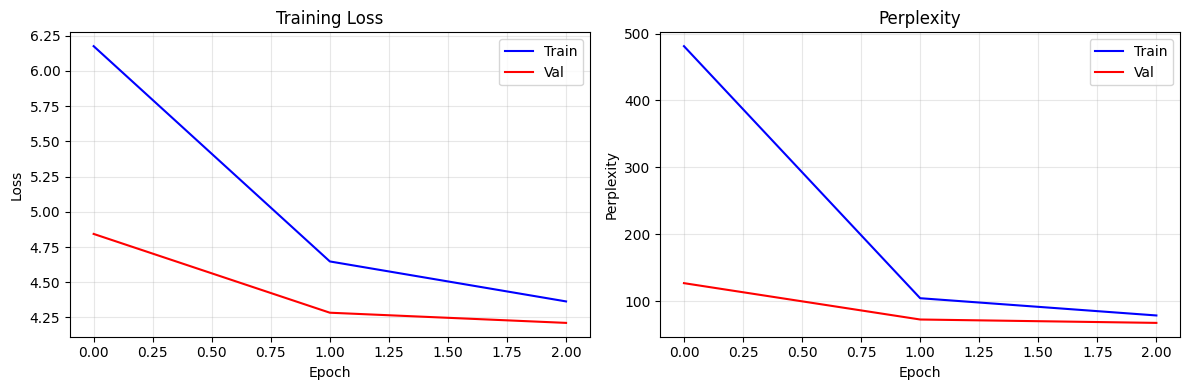

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(train_losses, 'b-', label='Train')
axes[0].plot(val_losses, 'r-', label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity
axes[1].plot([math.exp(l) for l in train_losses], 'b-', label='Train')
axes[1].plot([math.exp(l) for l in val_losses], 'r-', label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Perplexity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gpt2_training.png', dpi=150)
plt.show()

## 8. Генерация текста

In [23]:
def generate_text(model, tokenizer, prompt: str, max_length: int = 100, 
                  temperature: float = 0.8, top_k: int = 50, top_p: float = 0.9):
    model.eval()
    
    input_ids = tokenizer.encode(prompt)
    input_ids = torch.tensor([input_ids]).to(device)
    
    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(input_ids)
            next_token_logits = outputs.logits[0, -1, :] / temperature
            
            # Top-K
            if top_k > 0:
                indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][-1]
                next_token_logits[indices_to_remove] = float('-inf')
            
            # Top-P (nucleus)
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
                sorted_indices_to_remove[0] = False
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                next_token_logits[indices_to_remove] = float('-inf')
            
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
            
            if next_token.item() == tokenizer.eos_token_id:
                break
    
    return tokenizer.decode(input_ids[0].tolist())

In [24]:
prompts = [
    "Машинное обучение — это",
    "Россия является",
    "Нейронные сети используются для",
    "История человечества",
    "В современном мире",
]

print("ГЕНЕРАЦИЯ ТЕКСТА (GPT-2 + кастомный BPE токенизатор)")

for prompt in prompts:
    print(f"\nПромпт: '{prompt}'")
    print("-" * 40)
    
    generated = generate_text(
        model, tokenizer, prompt,
        max_length=50,
        temperature=0.8,
        top_k=50,
        top_p=0.9
    )
    print(f"{generated}")

ГЕНЕРАЦИЯ ТЕКСТА (GPT-2 + кастомный BPE токенизатор)

📝 Промпт: 'Машинное обучение — это'
----------------------------------------
🤖 Машинное обучение — это место как и в 1997 году. Зимёплое также пришлось в 1998 году. В конце октября 1993 года стал первым в 2000 году, где пришлось в 1998 году.

О

📝 Промпт: 'Россия является'
----------------------------------------
🤖 Россия является его венгерского происхождения.

Это есть, 400 50 % населения — 486,779 % населения — 797,87 % населения — 49,

📝 Промпт: 'Нейронные сети используются для'
----------------------------------------
🤖 Нейронные сети используются для их отбудения. Вместе с помощью удаёт на удаёт на удаёт на удаёт на удаёт на удаёт на удаёт на удаёт на удаёт на удаёт

📝 Промпт: 'История человечества'
----------------------------------------
🤖 История человечества, которые в том числе и нередко-кончание. В 1899 году в Москве был создан на улицах, когда он было обнаружено в своих полётах. В 1891 году в Москве был создан

📝 Промпт

## 9. Итоговая сводка

### Токенизатор (BPE)
| Параметр | Значение |
|----------|----------|
| Тип | Byte Pair Encoding (кастомная реализация) |
| Паттерн претокенизации | GPT-4 (cl100k_base) |
| Обучен на | Русская Википедия |
| Специальные токены | `<PAD>`, `<UNK>`, `<BOS>`, `<EOS>`, `<MASK>` |

### Данные
| Параметр | Значение |
|----------|----------|
| Корпус | Русская Википедия (`wikimedia/wikipedia, 20231101.ru`) |
| Формат | Streaming через HuggingFace datasets |

### Модель
| Параметр | Значение |
|----------|----------|
| Базовая модель | GPT-2 124M |
| Архитектура | 12 слоёв, 12 голов, 768 hidden dim |
| Transformer блоки | Скопированы из pretrained GPT-2 |
| Embedding слой | Инициализирован заново под новый словарь |

### Обучение
| Параметр | Значение |
|----------|----------|
| Оптимизатор | AdamW (weight_decay=0.01) |
| Scheduler | CosineAnnealing |
| Gradient clipping | 1.0 |

### Подход к замене токенизатора
1. Обучаем BPE токенизатор на русском корпусе
2. Создаём GPT-2 с новым `vocab_size`
3. Копируем веса всех transformer блоков из pretrained модели
4. Инициализируем embedding слой случайно (новый словарь)
5. Дообучаем на русском корпусе

Это позволяет использовать знания GPT-2 о структуре языка, но с токенизатором, оптимизированным для русского языка.

In [25]:
# Итоговые метрики
final_train_ppl = math.exp(train_losses[-1])
final_val_ppl = math.exp(val_losses[-1])

print("=" * 60)
print("РЕЗУЛЬТАТЫ")
print("=" * 60)

print(f"""
Размер словаря:     {tokenizer.get_vocab_size():,}
Параметров модели:  {sum(p.numel() for p in model.parameters()):,}
Устройство:         {device}

Train примеров:     {len(train_dataset):,}
Val примеров:       {len(val_dataset):,}

Train Perplexity:   {final_train_ppl:.2f}
Val Perplexity:     {final_val_ppl:.2f}
Ratio (Val/Train):  {final_val_ppl/final_train_ppl:.2f}x
""")

РЕЗУЛЬТАТЫ

Размер словаря:     5,000
Параметров модели:  89,682,432
Устройство:         cuda

Train примеров:     31,757
Val примеров:       7,883

Train Perplexity:   78.56
Val Perplexity:     67.46
Ratio (Val/Train):  0.86x



In [26]:
# Сохранение модели и токенизатора
tokenizer.save('bpe_tokenizer_ru.json')
torch.save(model.state_dict(), 'gpt2_russian_bpe.pt')

print("Модель и токенизатор сохранены!")

Модель и токенизатор сохранены!
